# Project

Welcome to the group project! The project is based on the [ACM RecSys 2021 Challenge](https://recsys-twitter.com/).

- Detailed information about the task, submission and grading can be found in a [dedicates site on TUWEL](https://tuwel.tuwien.ac.at/mod/page/view.php?id=1217340).
- Information about the dataset structure [on this site on TUWEL](https://tuwel.tuwien.ac.at/mod/page/view.php?id=1218810).

In [1]:
team_name = "Group 15"
team_members = [("Markus Böck","01634838"),
                ("","")] # [("Jane Doe","012345678"), ("John Doe","012345678")]


In [2]:
print(team_name)
print(team_members)

Group 15
[('Markus Böck', '01634838'), ('', '')]


In [3]:
path_to_data = '~/shared/data/project/training/'
val_path_to_data = '~/shared/data/project/validation/'
dataset_type = 'one_hour' # all_sorted, one_day, one_hour, one_week
val_dataset_type = "one_hour"

In [4]:
all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager", "reply", "retweet", "quote", "like"]

all_features_to_idx = dict(zip(all_features, range(len(all_features))))

## Item-Item Collaborative Filtering
#### Author: Markus Böck

In [5]:
from model import *

In [6]:
%%time
iicf = IICF(path_to_data, "one_day")

Found files: ['/home/e01634838/shared/data/project/training/one_day']
Tweet Features: {'photo': 0, 'video': 1, 'link': 2, 'retweet': 3, 'quote': 4, 'toplevel': 5, 'follower_count': 6, 'following_count': 7, 'verified': 8}
Tweet Targets: {'reply': 0, 'retweet': 1, 'quote': 2, 'like': 3}
Initialising "Ratings Matrix" ...
Reading ['/home/e01634838/shared/data/project/training/one_day'] ...
Read 64216542 entries.
Convert to DataFrame ...
Done!
Engagement means:
reply      0.027377
retweet    0.084515
quote      0.006820
like       0.377553
dtype: float64
Calculate tweet features ...
64216542/64216542 Done!

Finished initialisation!
CPU times: user 44min, sys: 1min 23s, total: 45min 23s
Wall time: 44min 56s


In [7]:
import os
import re
import csv
import datetime


def evaluate_test_set(path_to_data, dataset_type):
    expanded_path = os.path.expanduser(path_to_data)
    part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
    part_files = sorted(part_files, key = lambda x:x[-5:]) 
        
    i = 0
    with open('results.csv', 'w') as output:
        for file in part_files:
            with open(file, 'r') as f:
                linereader = csv.reader(f, delimiter='\x01')
                last_timestamp = None
                for row in linereader:
                    i += 1
                    tweet_id, user_id, features, follow, tweet_timestamp = iicf.parse_input_features(row) 

                    reply_pred, retweet_pred, quote_pred, fav_pred = iicf.predict(tweet_id, user_id, features, follow)
                    
                    # print(str(tweet_timestamp))
                    # print(str(reply_pred)+" "+str(retweet_pred)+" "+str(quote_pred)+" "+str(fav_pred))
                    
                    output.write(f'{tweet_id},{user_id},{reply_pred},{retweet_pred},{quote_pred},{fav_pred}\n')
                    
                    if i % 1000 == 0:
                        print(f"Predicted {i} rows.", end="\r")

    print(f"Predicted {i} rows.")

In [8]:
%%time
evaluate_test_set(val_path_to_data, val_dataset_type)

Predicted 84377 rows.
CPU times: user 1h 7min 56s, sys: 6min 38s, total: 1h 14min 34s
Wall time: 1h 14min 31s


In [9]:
# hidden


In [10]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])

    ctr = positive/float(len(gt))

    return ctr

def compute_rce(pred, gt):

    cross_entropy = log_loss(gt, pred)

    data_ctr = calculate_ctr(gt)

    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])

    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [11]:
val_expanded_path = os.path.expanduser(val_path_to_data)
val_part_files = [os.path.join(val_expanded_path, f) for f in os.listdir(val_expanded_path) if val_dataset_type in f]
val_part_files = sorted(val_part_files, key = lambda x:x[-5:])
val_part_files
val_data = pd.read_csv(val_part_files[0], delimiter='\x01', header=None, usecols=[2, 14, 20,21,22,23])
val_data.columns = ["tweet_id", "engaging_user_id", 'reply', 'retweet', 'quote', 'like']

val_data.reply = (~val_data.reply.isna()).astype("int")
val_data.retweet = (~val_data.retweet.isna()).astype("int")
val_data.quote = (~val_data.quote.isna()).astype("int")
val_data.like = (~val_data.like.isna()).astype("int")

val_data

,tweet_id,engaging_user_id,reply,retweet,quote,like
0,F1ACF09134D089766E7ED9599AF5BAAB,06581EA8BFF48387905AE44461A5E326,0,0,0,0
1,357F7ADACCC62DFE4239030C337E1203,8D4394F5025308A5EBD15E24A315378E,0,0,0,0
2,357F7ADACCC62DFE4239030C337E1203,DFA5260A0F9FE3D0F57D4BFC73EE0BE1,0,0,0,0
3,124572F51ECB70FB32FD236C0DCC49F9,B61D0A5B8AA47718490FCB03757402BF,0,0,0,0
4,AF7BCBA32384842B8D5A5A165DE74A96,362F40E439E0C773A8DB308E6E673313,0,0,0,1
...,...,...,...,...,...,...
84372,2A0B4C59EC449EC4A7EA1771DDB888D8,090719B8118D9D2F0CC010C4BA8648C8,0,0,0,0
84373,A533F79F65E5D277238C1DB40C9ADAAE,D27628FDF5CAE5C80295396D490A35C2,0,0,0,0
84374,8DFDF22F0D21CD5FD756896907282355,66D49C65447407A5837A2C20510DF7B2,0,0,0,1
84375,0E0404A93580C173B67E0F921971A2EB,FA314A78B5BFAEC6FC403D2C860752B9,0,0,0,0


In [12]:
results = pd.read_csv("results.csv", header=None)
results.columns = ["tweet_id", "user_id", "reply", "retweet", "quote", "like"]
results

,tweet_id,user_id,reply,retweet,quote,like
0,F1ACF09134D089766E7ED9599AF5BAAB,06581EA8BFF48387905AE44461A5E326,0.000000,0.000000,0.001893,0.554893
1,357F7ADACCC62DFE4239030C337E1203,8D4394F5025308A5EBD15E24A315378E,0.000000,0.391998,0.000000,0.122409
2,357F7ADACCC62DFE4239030C337E1203,DFA5260A0F9FE3D0F57D4BFC73EE0BE1,0.027377,0.084515,0.006820,0.314056
3,124572F51ECB70FB32FD236C0DCC49F9,B61D0A5B8AA47718490FCB03757402BF,0.027377,0.084515,0.006820,0.377553
4,AF7BCBA32384842B8D5A5A165DE74A96,362F40E439E0C773A8DB308E6E673313,0.017335,0.009016,0.000498,0.418035
...,...,...,...,...,...,...
84372,2A0B4C59EC449EC4A7EA1771DDB888D8,090719B8118D9D2F0CC010C4BA8648C8,0.027377,0.039739,0.006820,0.183523
84373,A533F79F65E5D277238C1DB40C9ADAAE,D27628FDF5CAE5C80295396D490A35C2,0.014640,0.019450,0.000905,0.455362
84374,8DFDF22F0D21CD5FD756896907282355,66D49C65447407A5837A2C20510DF7B2,0.027377,0.084515,0.006820,0.377553
84375,0E0404A93580C173B67E0F921971A2EB,FA314A78B5BFAEC6FC403D2C860752B9,0.023096,0.136719,0.003031,0.462635


In [13]:
print("Reply scores:")
compute_rce(results.reply, val_data.reply), average_precision_score(val_data.reply, results.reply)

Reply scores:


(-53.78785842110461, 0.037004776167208035)

In [14]:
print("Retweet scores:")
compute_rce(results.retweet, val_data.retweet), average_precision_score(val_data.retweet, results.retweet)

Retweet scores:


(-61.50166604736109, 0.11615123232744808)

In [15]:
print("Quote scores:")
compute_rce(results.quote, val_data.quote), average_precision_score(val_data.quote, results.quote)

Quote scores:


(-40.431230291216536, 0.01374908973759376)

In [16]:
print("Like scores:")
compute_rce(results.like, val_data.like), average_precision_score(val_data.like, results.like)

Like scores:


(-60.417186236457354, 0.4330282681329902)

In [17]:
del iicf # free up memory

## Data Analysis & Baselines
#### Author: Markus Böck

In [18]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

Collecting statistics:
- Number of rows
- Numer of unique users
- Number of unique tweets
- Percentage of engagements (reply, retweet, quote, like)
- Percentage of users of validation set appearing in training data

In [19]:
%%time

res = {}
for dataset_type in ["one_hour", "one_day", "one_week"]:
    expanded_path = os.path.expanduser(path_to_data)
    part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
    part_files = sorted(part_files, key = lambda x:x[-5:])
    part_files
    print(part_files)

    tweet_counts = dict()
    user_counts = dict()
    
    nreply = 0
    nretweet = 0
    nquote = 0
    nlike = 0
    nengagement = 0

    nrows = 0
    with open(part_files[0], 'r') as f:
        linereader = csv.reader(f, delimiter='\x01')
        last_timestamp = None
        i = 0
        tik = time.time()
        for row in linereader:
            tweet_id = row[all_features_to_idx['tweet_id']]
            user_id = row[all_features_to_idx['engaging_user_id']]
            
            reply = row[all_features_to_idx['reply']] != ""
            retweet = row[all_features_to_idx['retweet']] != ""
            quote = row[all_features_to_idx['quote']] != ""
            like = row[all_features_to_idx['like']] != ""
                
            nreply += reply
            nretweet += retweet
            nquote += quote
            nlike += like
            nengagement += (reply or retweet or quote or like)
                        
            v = 0
            try:
                v = tweet_counts[tweet_id]
            except:
                pass
            tweet_counts[tweet_id] = v + 1

            v = 0
            try:
                v = user_counts[user_id]
            except:
                pass
            user_counts[user_id] = v + 1

            if i % 100000 == 0:
                tok = time.time()
                print(f"{i} {100000/(tok-tik): .2f} iter/s", end="\r")
                tik = time.time()

            i += 1

        nrows = i
        
        stats = {"nrows": nrows}
        
        stats["nreply"] = nreply
        stats["nretweet"] = nretweet
        stats["nquote"] = nquote
        stats["nlike"] = nlike
        stats["nengagement"] = nengagement
        
        stats["unique_tweets"] = len(tweet_counts)
        stats["unique_users"] = len(user_counts)
        
        percs = []
        for i in range(1,11):
            perc = sum([1 for (j,c) in tweet_counts.items() if c >= i])  / len(tweet_counts)
            percs.append(perc)
        stats["tweet_dist"] = percs
        
        percs = []
        for i in range(1,11):
            perc = sum([1 for (j,c) in user_counts.items() if c >= i])  / len(user_counts)
            percs.append(perc)
        stats["user_dist"] = percs
        
        stats["val_user_perc"] = len(set(val_data["engaging_user_id"].unique()).intersection(set(user_counts.keys()))) / val_data.shape[0] * 100
        stats["val_tweet_perc"] = len(set(val_data["tweet_id"].unique()).intersection(set(tweet_counts.keys()))) / val_data.shape[0] * 100
        
        res[dataset_type] = stats

['/home/e01634838/shared/data/project/training/one_hour']
['/home/e01634838/shared/data/project/training/one_day']
['/home/e01634838/shared/data/project/training/one_week']
CPU times: user 46min 1s, sys: 1min 47s, total: 47min 49s
Wall time: 47min 38s


All data needs special treatment. Exploit the fact that this set is ordered according to tweet id.

In [20]:
%%time

dataset_type = "all_sorted"
expanded_path = os.path.expanduser(path_to_data)
part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
part_files = sorted(part_files, key = lambda x:x[-5:])
part_files
print(part_files)

current_tweet_id = ""
tweet_count = 1
tweet_dist = [0]*10
n_unique_tweets = 0

user_counts = dict()

nreply = 0
nretweet = 0
nquote = 0
nlike = 0
nengagement = 0

nrows = 0
with open(part_files[0], 'r') as f:
    linereader = csv.reader(f, delimiter='\x01')
    last_timestamp = None
    i = 0
    tik = time.time()
    for row in linereader:
        tweet_id = row[all_features_to_idx['tweet_id']]
        user_id = row[all_features_to_idx['engaging_user_id']]

        #print(tweet_id)
        
        if current_tweet_id == tweet_id:
            tweet_count += 1
        else:
            #print(tweet_id, tweet_count)
            for j in range(1, 11):
                if tweet_count >= j:
                    tweet_dist[j-1] += 1
            tweet_count = 1
            current_tweet_id = tweet_id
            n_unique_tweets += 1
                

        reply = row[all_features_to_idx['reply']] != ""
        retweet = row[all_features_to_idx['retweet']] != ""
        quote = row[all_features_to_idx['quote']] != ""
        like = row[all_features_to_idx['like']] != ""

        nreply += reply
        nretweet += retweet
        nquote += quote
        nlike += like
        nengagement += (reply or retweet or quote or like)


        v = 0
        try:
            v = user_counts[user_id]
        except:
            pass
        user_counts[user_id] = v + 1

        if i % 100000 == 0:
            tok = time.time()
            print(f"{i} {100000/(tok-tik): .2f} iter/s", end="\r")
            tik = time.time()

        i += 1


    nrows = i

    stats = {"nrows": nrows}

    stats["nreply"] = nreply
    stats["nretweet"] = nretweet
    stats["nquote"] = nquote
    stats["nlike"] = nlike
    stats["nengagement"] = nengagement

    stats["unique_tweets"] = n_unique_tweets
    stats["unique_users"] = len(user_counts)

    stats["tweet_dist"] = [d/n_unique_tweets for d in tweet_dist]

    percs = []
    for i in range(1,11):
        perc = sum([1 for (j,c) in user_counts.items() if c >= i])  / len(user_counts)
        percs.append(perc)
    stats["user_dist"] = percs

    stats["val_user_perc"] = len(set(val_data["engaging_user_id"].unique()).intersection(set(user_counts.keys()))) / val_data.shape[0] * 100
    stats["val_tweet_perc"] = 0.

res[dataset_type] = stats

['/home/e01634838/shared/data/project/training/all_sorted']
CPU times: user 1h 25min 54s, sys: 3min 21s, total: 1h 29min 16s
Wall time: 1h 28min 55s


In [21]:
del tweet_counts
del user_counts

In [22]:
# Print statistics
for (k,stats) in res.items():
    print(k)
    print("\tnrows", stats["nrows"])
    
    print("\tnreply", stats["nreply"], "-", round(stats["nreply"]/stats["nrows"]*100,2), "%")
    print("\tnretweet", stats["nretweet"], "-", round(stats["nretweet"]/stats["nrows"]*100,2), "%")
    print("\tnquote", stats["nquote"], "-", round(stats["nquote"]/stats["nrows"]*100,2), "%")
    print("\tnlike", stats["nlike"], "-", round(stats["nlike"]/stats["nrows"]*100,2), "%")
    print("\tnengagement", stats["nengagement"], "-", round(stats["nengagement"]/stats["nrows"]*100,2), "%")
          
    print("\tunique_tweets", stats["unique_tweets"])
    print("\tunique_users", stats["unique_users"])
    print("\tval_user_perc", stats["val_user_perc"])
    try:
        print("\tval_tweet_perc", stats["val_tweet_perc"])
    except KeyError:
        pass

one_hour
	nrows 891747
	nreply 19778 - 2.22 %
	nretweet 40240 - 4.51 %
	nquote 4683 - 0.53 %
	nlike 188438 - 21.13 %
	nengagement 240590 - 26.98 %
	unique_tweets 462701
	unique_users 723876
	val_user_perc 9.548810694857604
	val_tweet_perc 0.0
one_day
	nrows 64216542
	nreply 1758039 - 2.74 %
	nretweet 5427247 - 8.45 %
	nquote 437925 - 0.68 %
	nlike 24245123 - 37.76 %
	nengagement 30416121 - 47.36 %
	unique_tweets 29288894
	unique_users 15368445
	val_user_perc 73.52596086611281
	val_tweet_perc 0.0
one_week
	nrows 260523602
	nreply 7240531 - 2.78 %
	nretweet 22656544 - 8.7 %
	nquote 1803980 - 0.69 %
	nlike 103001406 - 39.54 %
	nengagement 128627453 - 49.37 %
	unique_tweets 118041598
	unique_users 27923088
	val_user_perc 91.92552472830273
	val_tweet_perc 0.0
all_sorted
	nrows 684824551
	nreply 19038522 - 2.78 %
	nretweet 59772803 - 8.73 %
	nquote 4693368 - 0.69 %
	nlike 271151475 - 39.59 %
	nengagement 338693842 - 49.46 %
	unique_tweets 308657272
	unique_users 35699653
	val_user_perc 97.73

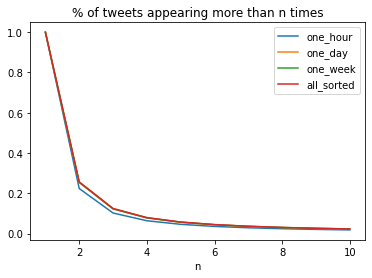

In [23]:
fig = plt.figure()
for (k,stats) in res.items():
    dist = stats["tweet_dist"]
    plt.plot(range(1,len(dist)+1), dist, label=k)
    
plt.legend()
plt.title("% of tweets appearing more than n times")
plt.xlabel("n")
#plt.yscale("log")
plt.savefig("tweets.pdf")

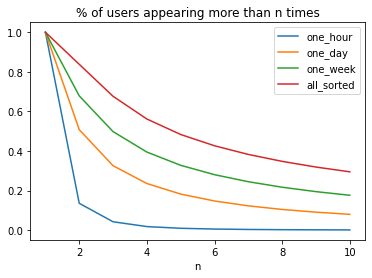

In [24]:
fig = plt.figure()
for (k,stats) in res.items():
    dist = stats["user_dist"]
    plt.plot(range(1,len(dist)+1), dist, label=k)
    
plt.legend()
plt.title("% of users appearing more than n times")
plt.xlabel("n")
#plt.yscale("log")
plt.savefig("users.pdf")

### Baselines

#### Predicting mean engagement

In [25]:
for (k,stats) in res.items():
    print(k)
    
    nvalrows = val_data.shape[0]
    reply_mean = stats["nreply"]/stats["nrows"]
    retweet_mean = stats["nretweet"]/stats["nrows"]
    quote_mean = stats["nquote"]/stats["nrows"]
    like_mean = stats["nlike"]/stats["nrows"]
    
    p = np.full(nvalrows, reply_mean)
    gt = val_data.reply
    print("reply:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
    p = np.full(nvalrows, retweet_mean)
    gt = val_data.retweet
    print("retweet:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
    p = np.full(nvalrows, quote_mean)
    gt = val_data.quote
    print("quote:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
    p = np.full(nvalrows, like_mean)
    gt = val_data.like
    print("like:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))

one_hour
reply: rce -0.0016726810437628359 avgprec 0.02245872690425116
retweet: rce -2.572690783808995 avgprec 0.07083683942306553
quote: rce -0.11509200136881059 avgprec 0.005925785462863102
like: rce -14.574136296620033 avgprec 0.4079192196925702
one_day
reply: rce -0.44972336106225974 avgprec 0.02245872690425116
retweet: rce -0.4978792261649545 avgprec 0.07083683942306553
quote: rce -0.16999390313110485 avgprec 0.005925785462863102
like: rce -0.28735574412810383 avgprec 0.4079192196925702
one_week
reply: rce -0.523603374675452 avgprec 0.02245872690425116
retweet: rce -0.6799674856781346 avgprec 0.07083683942306553
quote: rce -0.21006890934760492 avgprec 0.005925785462863102
like: rce -0.048601471801923424 avgprec 0.4079192196925702
all_sorted
reply: rce -0.5251393845349783 avgprec 0.02245872690425116
retweet: rce -0.7053052267925519 avgprec 0.07083683942306553
quote: rce -0.1825136341622846 avgprec 0.005925785462863102
like: rce -0.044201183172476455 avgprec 0.4079192196925702


#### Predicting no engagement

In [26]:
nvalrows = val_data.shape[0]
reply_pred = 0.
retweet_pred = 0.
quote_pred = 0.
like_pred = 0.

p = np.full(nvalrows, reply_pred)
gt = val_data.reply
print("reply:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
p = np.full(nvalrows, retweet_pred)
gt = val_data.retweet
print("retweet:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
p = np.full(nvalrows, quote_pred)
gt = val_data.quote
print("quote:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))
p = np.full(nvalrows, like_pred)
gt = val_data.like
print("like:", "rce", compute_rce(p, gt), "avgprec", average_precision_score(gt, p))

reply: rce -621.8494688006682 avgprec 0.02245872690425116
retweet: rce -856.4639059962117 avgprec 0.07083683942306553
quote: rce -463.85482181351927 avgprec 0.005925785462863102
like: rce -1983.891730766273 avgprec 0.4079192196925702
